In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import matplotlib.patches as mpatches

from matplotlib.collections import PatchCollection
import matplotlib

In [2]:
#list of number of link that are assigned
linkSummary = pd.read_csv('geomInfo/ModuleLinkSummary.csv')
linkSummary = linkSummary[(linkSummary.Cassette==0) & (linkSummary.Layer>=5) & (linkSummary.Layer<=9)]
linkSummary.set_index(['Layer','ModU','ModV'],inplace=True)


In [3]:
#load data from csv files.  This is used to extract average data sizes

#daq_Data = pd.concat([pd.read_csv(f'Data/ttbar_copy_new.csv') for i in range(16)])
daq_Data = pd.read_csv(f'Data/ttbar_copy_new.csv')

In [4]:
#get list of wedges, and assign x and y positions for drawing maps
wedges = daq_Data.groupby(['layer','waferu','waferv']).any()[['HDM']].reset_index()

wedges['y'] = wedges.waferv
wedges['x'] = 0
wedges.loc[:,'x'] = (2+wedges.y-2*wedges.waferu)
wedges.y *= 1.5
wedges.x *= -3**.5/2
wedges.set_index(['layer','waferu','waferv'],inplace=True)

In [5]:
daq_Data

,entry,layer,waferu,waferv,HDM,occ,eRxPacket_Words,NonEmptyLinks,EmptyLinks,TotalWords
0,4007,5,11,6,False,1,3,1,5,12
1,54000,5,11,5,False,1,3,1,5,12
2,54008,5,11,5,False,1,3,1,5,12
3,4000,5,10,8,False,4,10,3,3,17
4,4001,5,10,8,False,3,9,3,3,16
...,...,...,...,...,...,...,...,...,...,...
837196,51493,9,10,8,False,1,3,1,5,12
837197,51494,9,10,8,False,1,3,1,5,12
837198,51493,9,10,9,False,4,6,1,5,15
837199,51490,9,11,5,False,5,8,2,4,16


In [6]:
#function to look through output logs of condor jobs to extract and accumulate the results across several runs
# if you just ran interactivel, need to just get the info on the overflows, max size, etc into a dataframe.

def getDF(inputDF, LogName=None,Nstart=0,N=100):
    fullData = inputDF.groupby(['layer','waferu','waferv']).mean()
    fullData['eTx_assigned'] = linkSummary.ECOND_eTX
    fullData.eTx_assigned = fullData.eTx_assigned.fillna(1).astype(int)

    fullData['eTx_30percent'] = np.ceil((fullData.TotalWords/53.3333)*1.3).astype(int)
    fullData['eTx_Mean'] = np.ceil((fullData.TotalWords/53.3333))
    
    if not LogName is None:
        data_overflow = []
        data_maxSize = []
        L1As_issued=0
        fileName = f'log_100/{LogName}_{Nstart}.stdout'
        with open(fileName,'r') as _file:
            for line in _file:
                if 'overflows= ' in line:
                    data_overflow.append(eval(line[10:]))
                if 'maxSize= ' in line:
                    data_maxSize.append(eval(line[8:]))
                if 'L1As issued' in line:
                    L1As_issued += int(line.split()[0])
                    
        data_overflow=np.array(data_overflow)
        data_maxSize=np.array(data_maxSize)

        for i_file in range(Nstart+1,Nstart+N):
            #print(fileName)
            fileName = f'log_100/{LogName}_{i_file}.stdout'
            with open(fileName,'r') as _file:
                for line in _file:
                    if 'eTx' in line:
                        i = int(line.split()[0])-1
                    if 'overflows= ' in line:
                        overflow=np.array(eval(line[10:]))
                        overflow[overflow<0] = 99999999
                        data_overflow[i] += overflow
                    if 'maxSize= ' in line:
                        maxSize=np.array(eval(line[8:]))
                        data_maxSize[i] = np.maximum(data_maxSize[i], maxSize)
                    if 'L1As issued' in line:
                        L1As_issued += int(line.split()[0])
        
        #print(data_overflow)
        x = ((data_overflow.transpose()==0)*np.arange(1,7))
        x[x==0]=99
        minLinks = x.min(axis=1)
        fullData['min_eTx'] = minLinks

        nLinks = minLinks
        maxSize = []
        for i in range(len(nLinks)):
            maxSize.append(data_maxSize.transpose()[i][nLinks[i]-1])
        fullData['maxSize'] = maxSize    

        
        nLinks = fullData.eTx_assigned.values
        maxSize = []
        overflows = []
        for i in range(len(nLinks)):
            maxSize.append(data_maxSize.transpose()[i][nLinks[i]-1])
            overflows.append(data_overflow.transpose()[i][nLinks[i]-1])
        fullData['maxSize_assigned'] = maxSize
        fullData['overflows_assigned'] = overflows


        nLinks = fullData.eTx_30percent.values
        maxSize = []
        overflows = []
        for i in range(len(nLinks)):
            maxSize.append(data_maxSize.transpose()[i][nLinks[i]-1])
            overflows.append(data_overflow.transpose()[i][nLinks[i]-1])
        fullData['maxSize_30percent'] = maxSize
        fullData['overflows_30percent'] = overflows
    return fullData, L1As_issued, data_overflow, data_maxSize

In [7]:
fullData,L1As,OF, MS = getDF(daq_Data,LogName='bufferSim__34530053',Nstart=0,N=10)
print(L1As)

7504511


In [19]:
OF[0]

array([5565561, 4885355, 4395748, 4984351, 4985066, 2593800, 3342302,
       3590438, 3341167,       0,       0, 1944854, 1941414,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0, 5478775, 4797796, 4132909,
       4789310, 4791100, 2214395, 3006696, 3259405, 3000650,       0,
             0, 1503984, 1507330,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,     

In [20]:
OF[3]

array([313589,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0, 177033,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,  17946,      0,      0,      0,
      

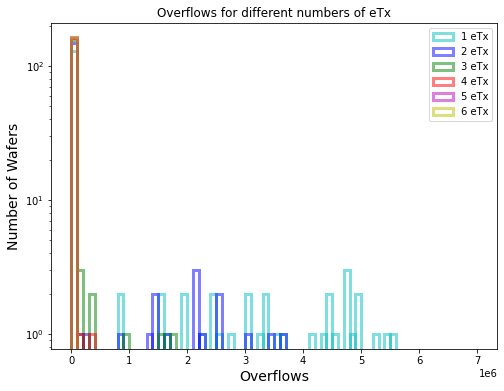

In [29]:
plt.figure(figsize=(8,6))
plt.hist(OF[0], bins=70, alpha=0.5, label="1 eTx", fill=False, linewidth=3, edgecolor='c',range=[0.0, 0.7e7])
plt.hist(OF[1], bins=70, alpha=0.5, label="2 eTx", fill=False, linewidth=3, edgecolor='b',range=[0.0, 0.7e7])
plt.hist(OF[2], bins=70, alpha=0.5, label="3 eTx", fill=False, linewidth=3, edgecolor='g',range=[0.0, 0.7e7])
plt.hist(OF[3], bins=70, alpha=0.5, label="4 eTx", fill=False, linewidth=3, edgecolor='r',range=[0.0, 0.7e7])
plt.hist(OF[4], bins=70, alpha=0.5, label="5 eTx", fill=False, linewidth=3, edgecolor='m',range=[0.0, 0.7e7])
plt.hist(OF[5], bins=70, alpha=0.5, label="6 eTx", fill=False, linewidth=3, edgecolor='y',range=[0.0, 0.7e7])
plt.xlabel("Overflows", size=14)
plt.ylabel("Number of Wafers", size=14)
plt.yscale('log')
plt.title("Overflows for different numbers of eTx")
plt.legend(loc='upper right')

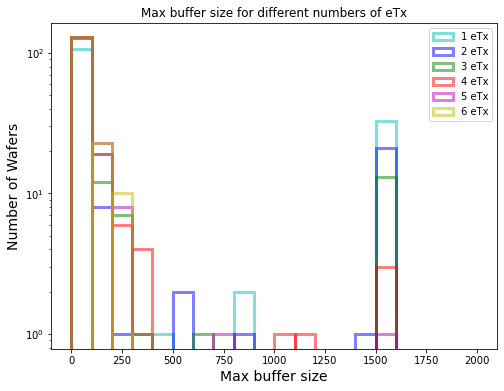

In [15]:
plt.figure(figsize=(8,6))
plt.hist(MS[0], bins=20, alpha=0.5, label="1 eTx", fill=False, linewidth=3, edgecolor='c',range=[0.0, 2000])
plt.hist(MS[1], bins=20, alpha=0.5, label="2 eTx", fill=False, linewidth=3, edgecolor='b',range=[0.0, 2000])
plt.hist(MS[2], bins=20, alpha=0.5, label="3 eTx", fill=False, linewidth=3, edgecolor='g',range=[0.0, 2000])
plt.hist(MS[3], bins=20, alpha=0.5, label="4 eTx", fill=False, linewidth=3, edgecolor='r',range=[0.0, 2000])
plt.hist(MS[4], bins=20, alpha=0.5, label="5 eTx", fill=False, linewidth=3, edgecolor='m',range=[0.0, 2000])
plt.hist(MS[5], bins=20, alpha=0.5, label="6 eTx", fill=False, linewidth=3, edgecolor='y',range=[0.0, 2000])
plt.xlabel("Max buffer size", size=14)
plt.ylabel("Number of Wafers", size=14)
plt.yscale('log')
plt.title("Max buffer size for different numbers of eTx")
plt.legend(loc='upper right')

entry    HDM         occ  eRxPacket_Words  \
layer waferu waferv                                                     
5     2      0       28747.000000   True  258.761616       204.543434   
             1       28747.000000   True  180.123232       146.592593   
      3      0       28747.000000   True  160.794613       127.088889   
             1       28747.000000   True  205.628283       157.687542   
             2       28747.000000   True  205.739394       157.758754   
...                           ...    ...         ...              ...   
9     10     7       28851.430713  False    2.302885         5.459559   
             8       28364.385196  False    1.992454         4.802731   
             9       28845.041045  False    1.481343         3.686567   
      11     5       28674.076263  False    1.415634         3.633937   
             6       29321.200188  False    1.458647         3.660714   

                     NonEmptyLinks  EmptyLinks  TotalWords  eTx_assigned  \
layer waferu waferv                                                        
5     2      0           11.997643    0.002357  208.545791             5   
             1            8.898148    3.101852  153.694444             3   
      3      0           11.997980    0.002020  131.090909             5   
             1           12.000000    0.000000  161.687542             6   
             2           11.999832    0.000168  161.758923             6   
...                            ...         ...         ...           ...   
9     10     7            1.606900    4.393100   13.852658             1   
             8            1.424362    4.575638   13.378369             1   
             9            1.117537    4.882463   12.569030             1   
      11     5            1.119161    4.880839   12.514776             1   
             6            1.114662    4.885338   12.546053             1   

                     eTx_30percent  eTx_Mean  min_eTx  maxSize  \
layer waferu waferv                                              
5     2      0                   6       4.0        6      312   
             1                   4       3.0        4      337   
      3      0                   4       3.0        4      290   
             1                   4       4.0        4     1181   
             2                   4       4.0        4     1213   
...                            ...       ...      ...      ...   
9     10     7                   1       1.0        1       46   
             8                   1       1.0        1       34   
             9                   1       1.0        1       23   
      11     5                   1       1.0        1       26   
             6                   1       1.0        1       22   

                     maxSize_assigned  overflows_assigned  maxSize_30percent  \
layer waferu waferv                                                            
5     2      0                   1536                 851                312   
             1                   1536             1756831                337   
      3      0                    250                   0                290   
             1                    239                   0               1181   
             2                    221                   0               1213   
...                               ...                 ...                ...   
9     10     7                     46                   0                 46   
             8                     34                   0                 34   
             9                     23                   0                 23   
      11     5                     26                   0                 26   
             6                     22                   0                 22   

                     overflows_30percent  
layer waferu waferv                       
5     2      0                         0  
             1                         0  
      3      0   

In [36]:
#dictionaly of the labels for different types of plots
Labels ={'occ':{'Title':'Average L1A Occupancy, Layer %i',
                'colorLabel':'Avg. Occ. Above Zero Suppression',
                'nDec':1,
                'zMax':260},
         'TotalWords':{'Title':'Average L1A Size (32b Words), Layer %i',
                      'colorLabel':'Avg. L1A Size (32b words)',
                      'nDec':1,
                      'zMax':200},
         'EmptyLinks':{'Title':'Average Number of Empty eRx Packets, Layer %i',
                      'colorLabel':'Avg. # of Empty eRx Packets',
                      'nDec':1,
                      'zMax':6},
         'eTx_assigned':{'Title':'Number of eTx assigned, Layer %i',
                      'colorLabel':'# of eTx',
                      'nDec':0,
                      'zMax':6},
         'eTx_30percent':{'Title':'Number of eTx assuming 30 percent overhead, Layer %i',
                      'colorLabel':'# of eTx',
                      'nDec':0,
                      'zMax':6},
         'eTx_Mean':{'Title':'Number of eTx based on mean data, no rounding, Layer %i',
                      'colorLabel':'# of eTx',
                      'nDec':2,
                      'zMax':6},
         'min_eTx':{'Title':'Min number of eTx with 0 overflows, Layer %i',
                      'colorLabel':'# of eTx',
                      'nDec':0,
                      'zMax':6},
         'maxSize':{'Title':'Max buffer size, with 0 overflows, Layer %i',
                      'colorLabel':'Buffer size (32b words)',
                      'nDec':0,
                      'zMax':1600},
         'maxSize_assigned':{'Title':'Max buffer size, using assigned number of links, Layer %i',
                      'colorLabel':'Buffer size (32b words)',
                      'nDec':0,
                      'zMax':1600},
         'overflows_assigned':{'Title':'Overflow counter, using assigned number of links, Layer %i',
                      'colorLabel':'# of buffer overflows',
                      'nDec':0,
                      'zMax':40000},
         'maxSize_30percent':{'Title':'Max buffer size, using link assignment from 30 percent overhead, Layer %i',
                      'colorLabel':'Buffer size (32b words)',
                      'nDec':0,
                      'zMax':1600},
         'overflows_30percent':{'Title':'Overflow counter, using link assignment from 30 percent overhead, Layer %i',
                      'colorLabel':'# of buffer overflows',
                      'nDec':0,
                      'zMax':40000},
        }

In [45]:
def makePlot(var,patches,df=fullData,extra=""):
    data = df.loc[layer,var].values.flatten()

    waferCollection = PatchCollection(patches,cmap=matplotlib.cm.coolwarm)
    waferCollection.set_array(data)
    waferCollection.set_clim([0,Labels[var]['zMax']])
    fig, ax = plt.subplots(figsize=(15,10))
    ax.add_collection(waferCollection)
    plt.axis([0,16,-1,15])
    plt.rcParams["figure.autolayout"] = True
    # ax.set_xticklabels([])
    # ax.set_yticklabels([]);
    cbar = plt.colorbar(waferCollection)
    cbar.set_label(Labels[var]['colorLabel'],fontsize=14)

    wedge['data'] = data

    plt.title(Labels[var]['Title']%layer,fontsize=24)
    for x,y,d in wedge[['x','y','data']].values:
    #     s = data[i]
        plt.text(x,y,f'%.{Labels[var]["nDec"]}f'%d,fontsize=14,horizontalalignment='center',verticalalignment='center')

                 

    fig.savefig(f'Plots/{var}_layer{layer}{extra}.png')

occ


<ipython-input-45-1298c94c0fb2>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wedge['data'] = data


TotalWords
EmptyLinks
eTx_assigned
eTx_30percent
eTx_Mean
min_eTx
maxSize
maxSize_assigned
overflows_assigned
maxSize_30percent
overflows_30percent


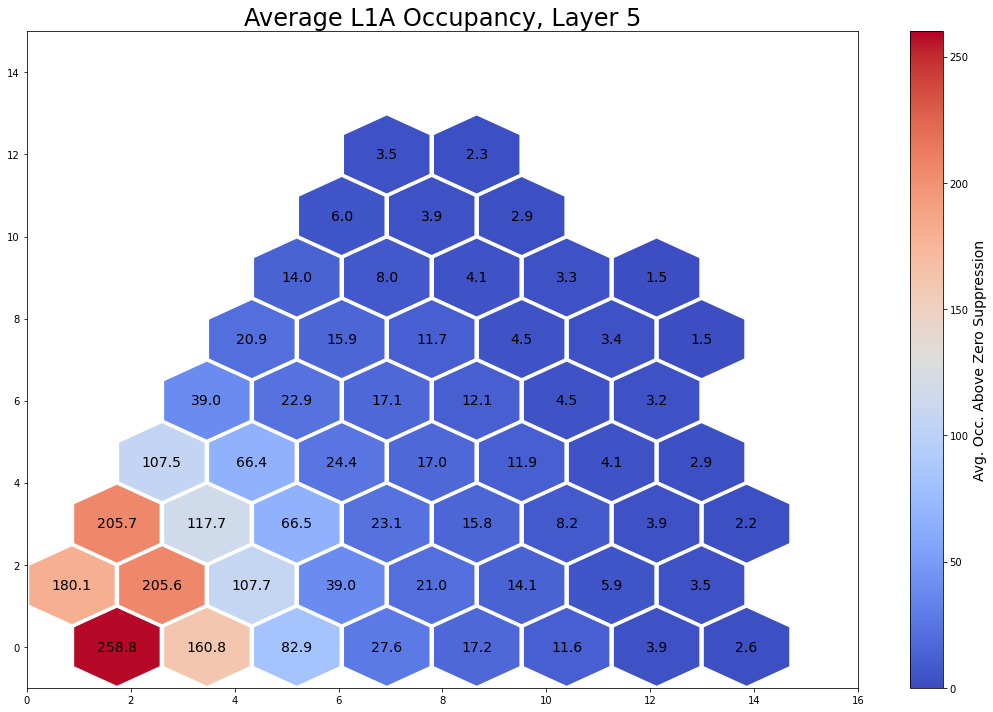

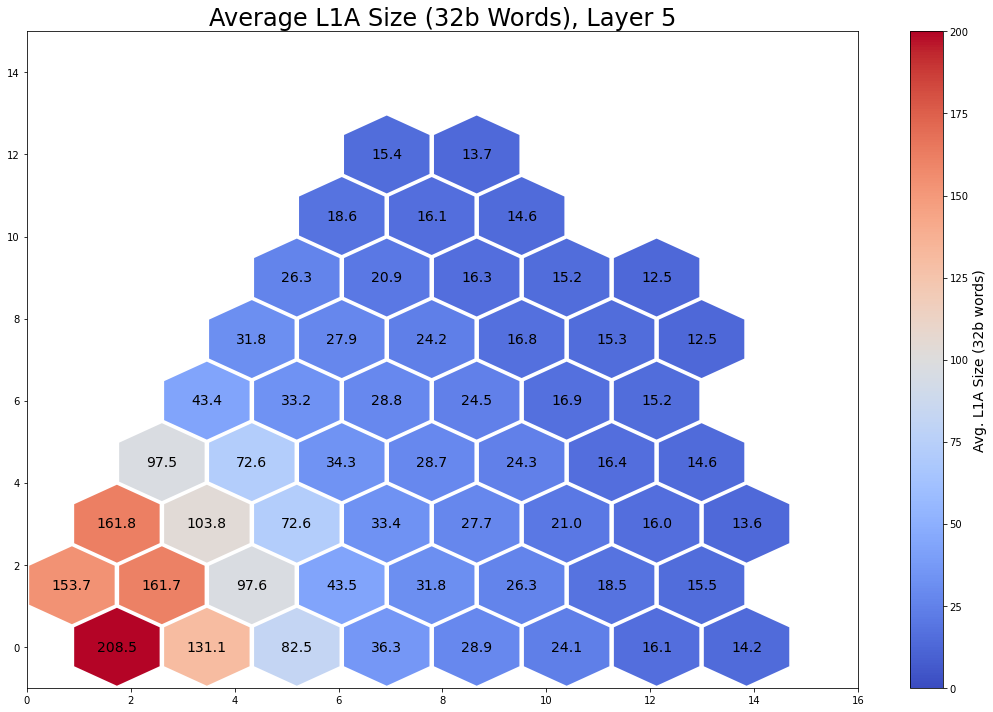

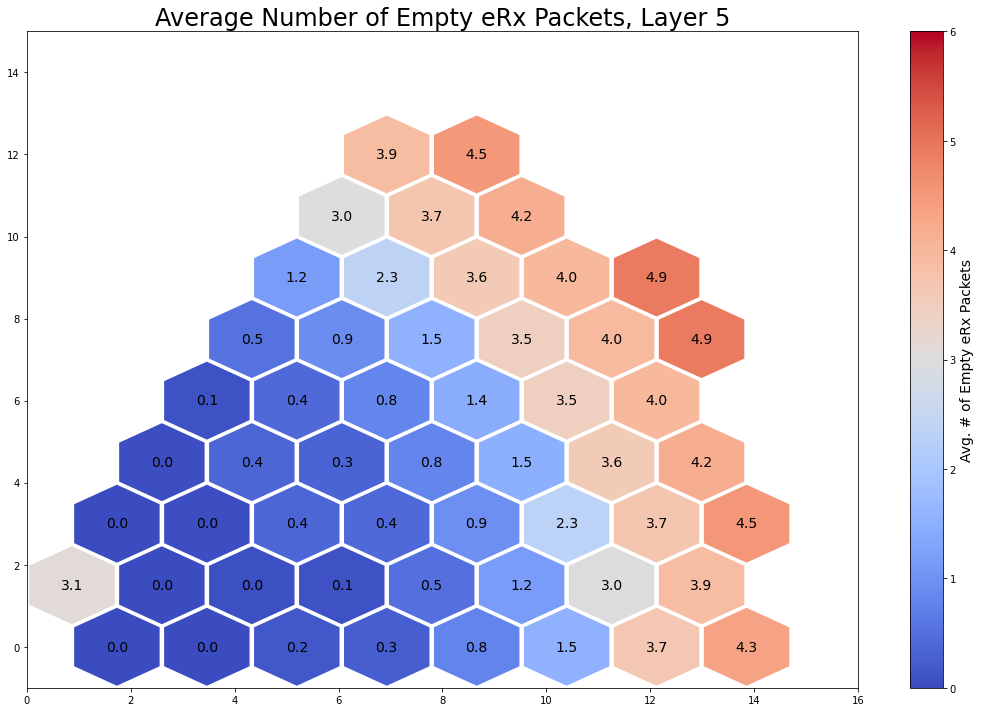

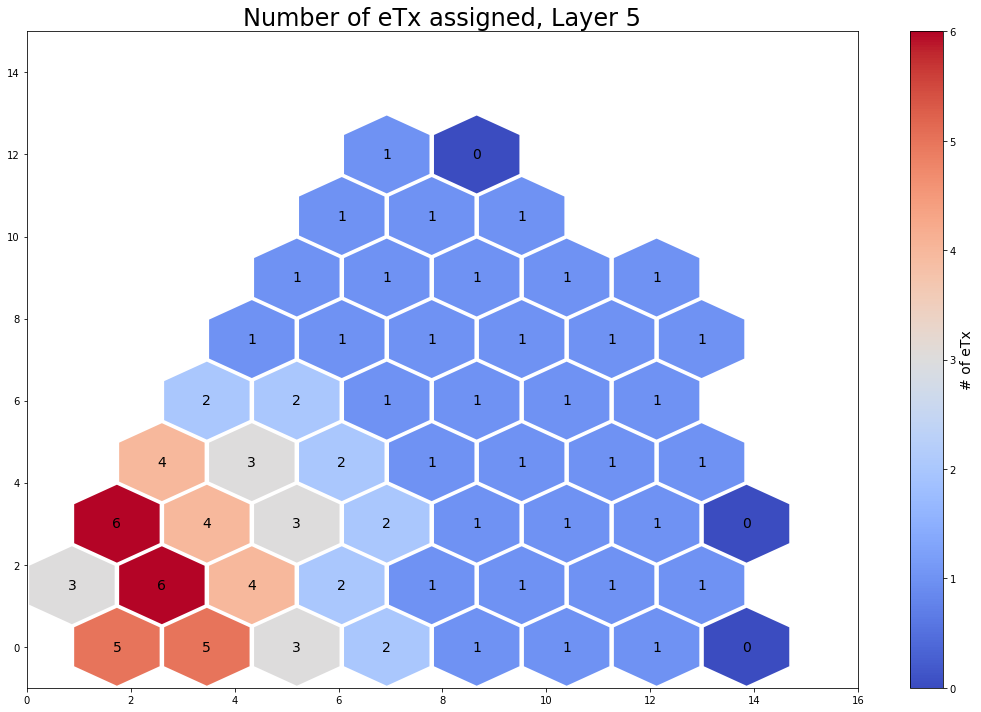

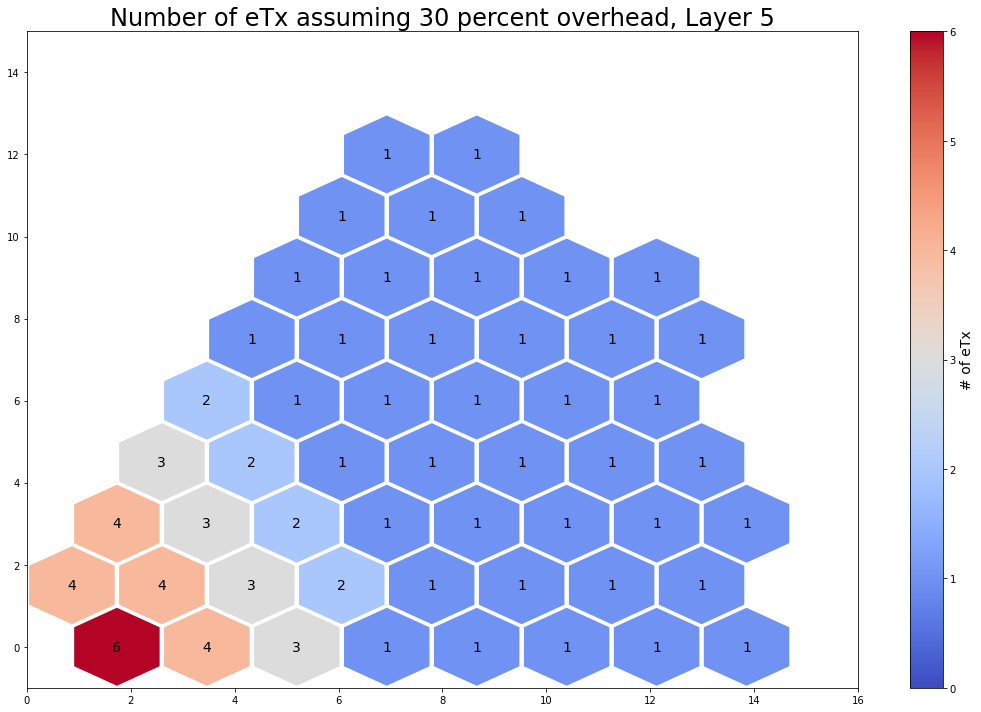

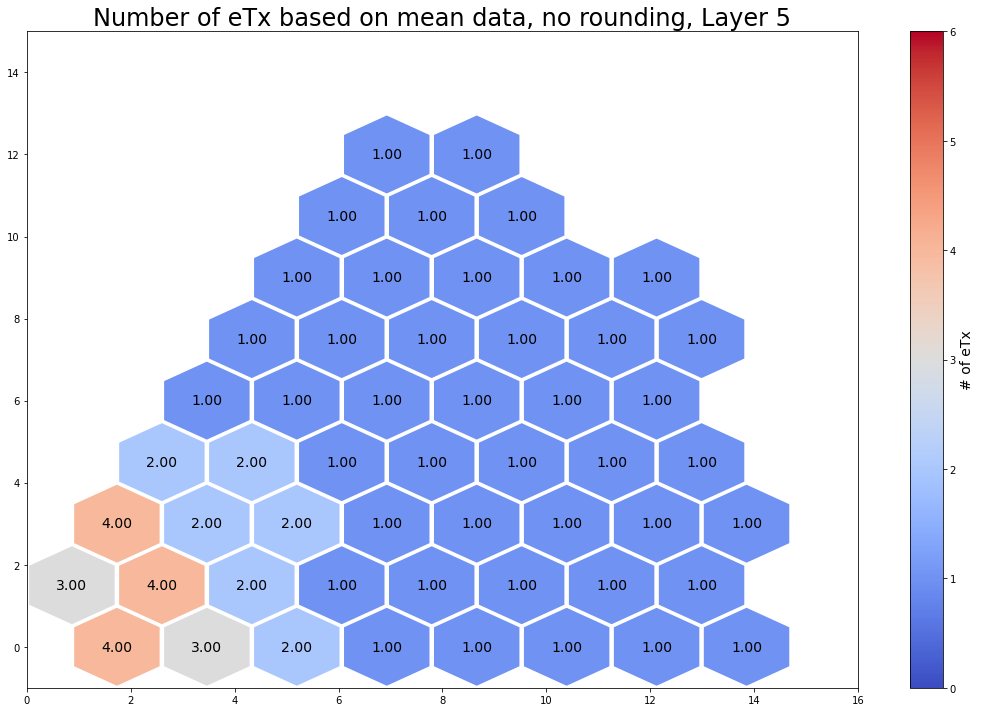

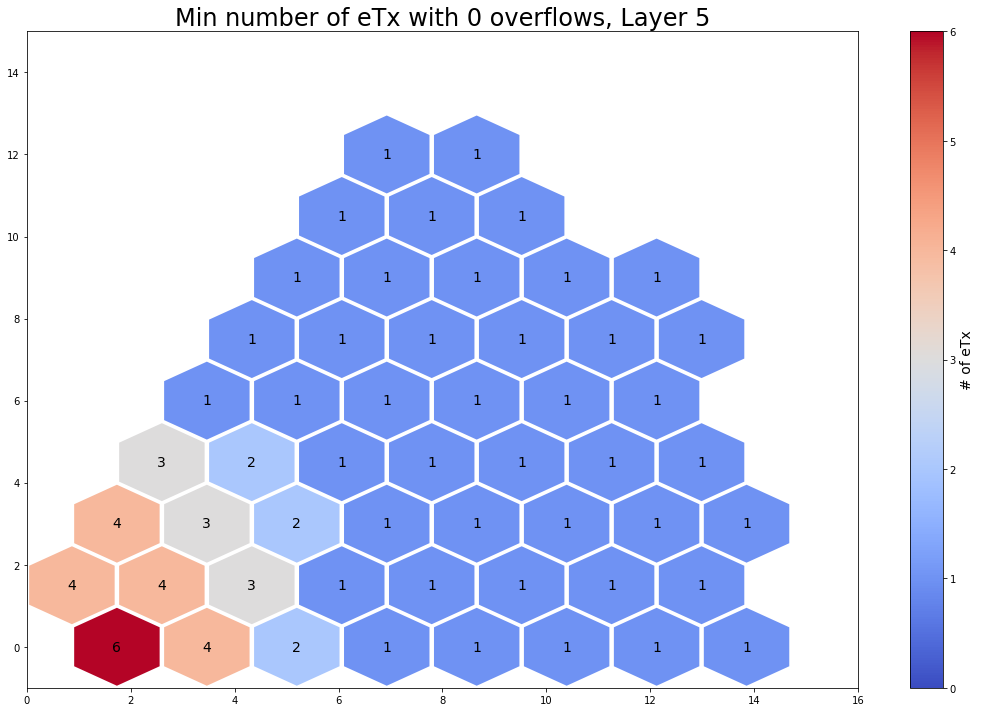

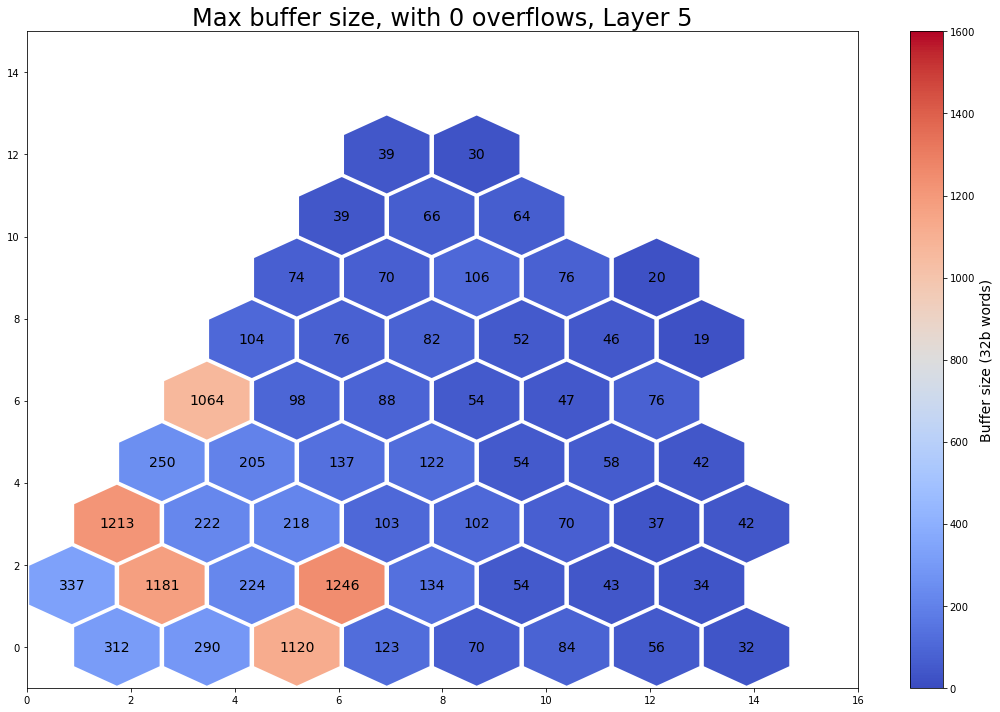

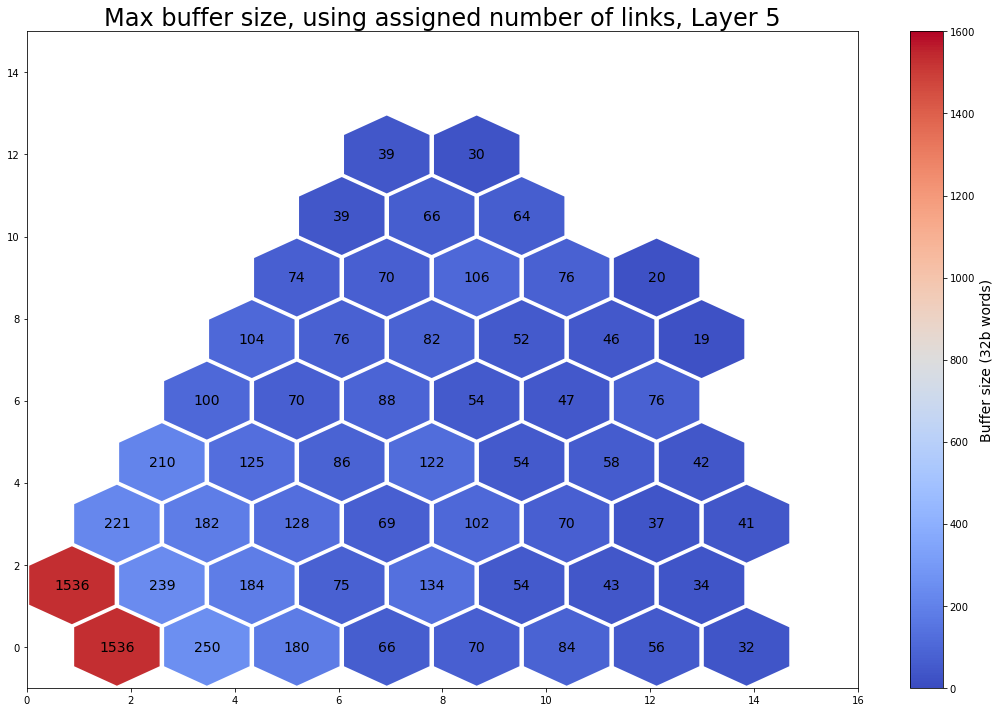

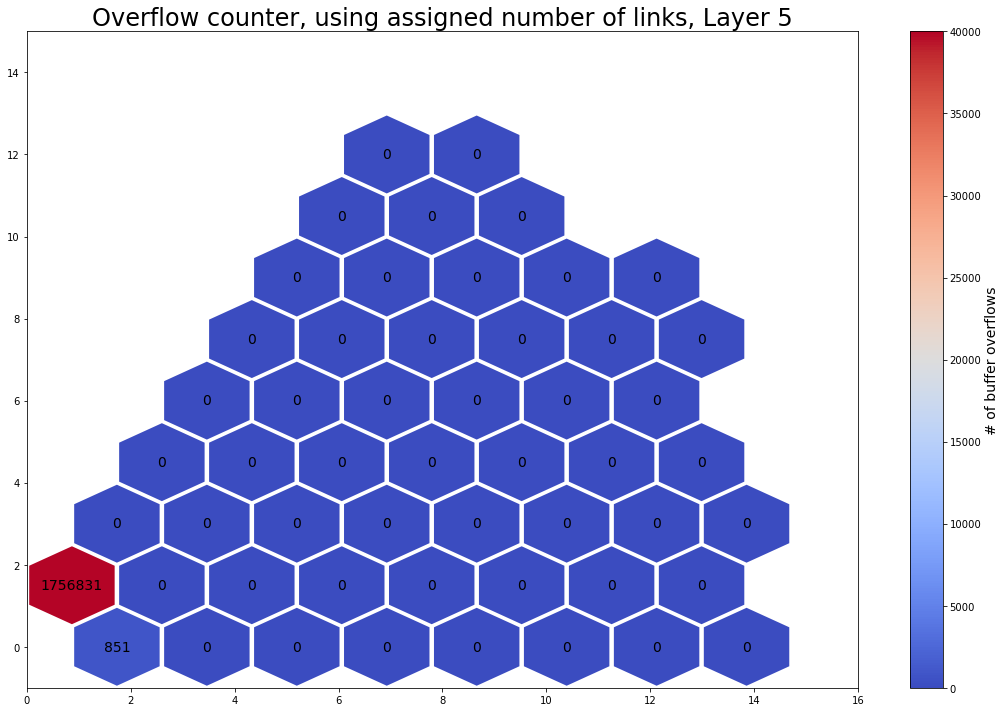

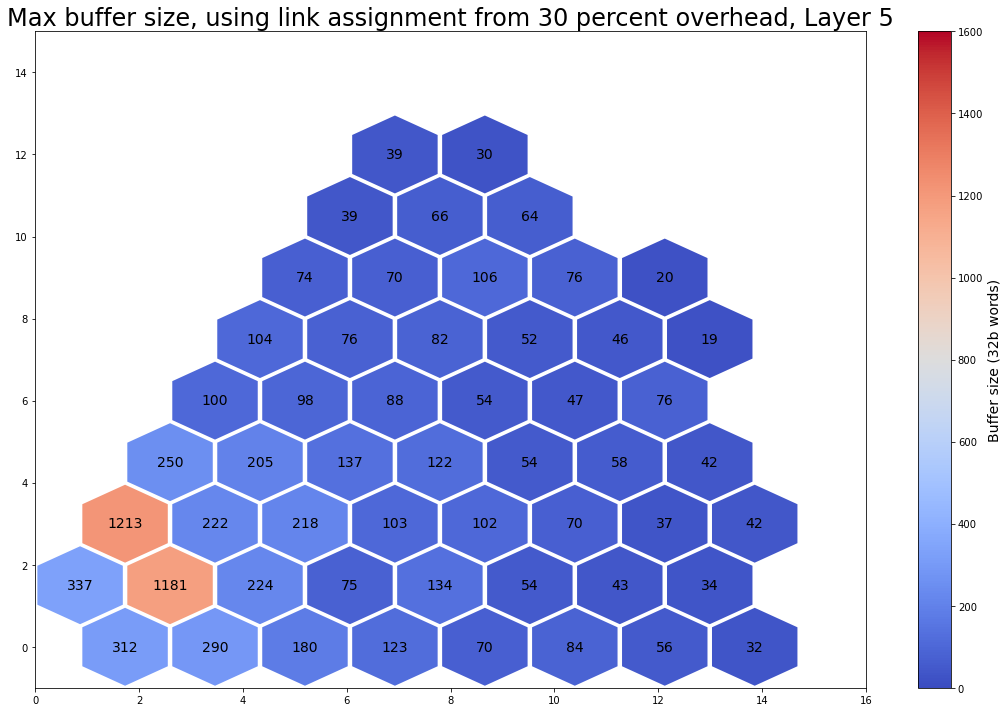

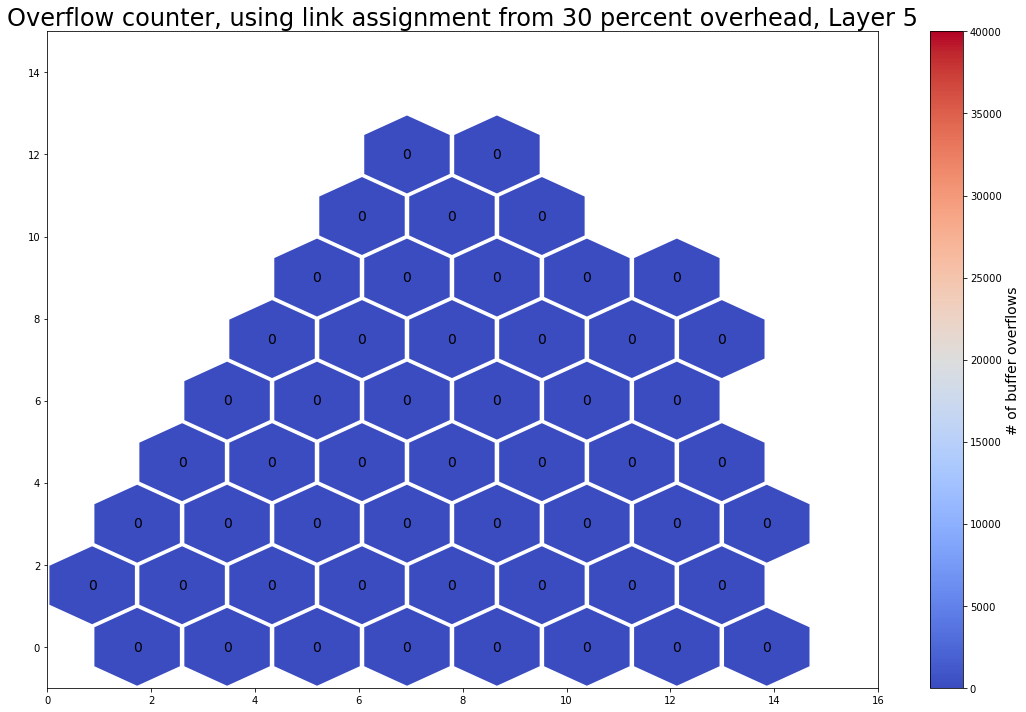

In [46]:
#for layer in [5,7,9]:
for layer in [5]:
    wedge = wedges.loc[layer]
    patches = []

    for w in wedge.index:
        patches.append(mpatches.RegularPolygon((wedge.loc[w].x,wedge.loc[w].y),6,.95))
    for k in Labels:
        print(k)
        makePlot(k,df=fullData,extra="_OldTTbarTests",patches=patches)
